In [1]:
import matplotlib.pyplot as plt
import cython
%load_ext cython

# Arbitrary Additional Arguments

## Additional Args = Array of Doubles

In [2]:
%%cython --force 
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin

from CyRK cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType, MAX_STEP, CySolveOutput, PreEvalFunc

cdef void pendulum_diffeq(double* dy_ptr, double t, double* y_ptr, char* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    # Arguments are passed in as char pointers.
    # These point to preallocated and instantiated memory in the CySolver class that is filled with user-provided data.

    # The user can then recast the generic char pointers back to original format of args_ptr. In this case, an array of doubles. 
    # Seg faults will occur if this function recasts to the incorrect type.
    cdef double* args_dbl_ptr = <double*>args_ptr
    cdef double l = args_dbl_ptr[0]
    cdef double m = args_dbl_ptr[1]
    cdef double g = args_dbl_ptr[2]

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double y0, y1, torque
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    # External torque
    torque = 0.1 * sin(t)

    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * torque


# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_diffeq

    # Define time domain
    cdef double[2] time_span_arr = [0.0, 10.0]
    cdef double* t_span_ptr = &time_span_arr[0]
    
    # Define initial conditions
    cdef double[2] y0_arr = [0.01, 0.0]
    cdef double* y0_ptr = &y0_arr[0]
    
    # Define our arguments.
    cdef double[3] args_arr = [1.0, 1.0, 9.81]
    cdef double* args_dbl_ptr = &args_arr[0]

    # We need to tell CySolver the size of the additional argument structure so that it can make a copy.
    cdef size_t size_of_args = sizeof(double) * 3

    # To work with cysolve_ivp, we must cast the args ptr to a char pointer
    cdef char* args_ptr = <char*>args_dbl_ptr

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        2,  # Number of dependent variables
        method = 1, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_ptr = args_ptr,
        size_of_args = size_of_args
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result

result_reg = run()
print("\n\nIntegration success =", result_reg.success, "\n\tNumber of adaptive time steps required:", result_reg.size)
print("Integration message:", result_reg.message)

Content of stdout:
_cython_magic_cb0cea1b8369ca28ab20a696845857f74ca6bd63.cpp
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\dense.cpp(155): warning C5051: attribute [[unlikely]] requires at least '/std:c++20'; ignored
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\cysolution.cpp(76): warning C5051: attribute [[unlikely]] requires at least '/std:c++20'; ignored
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\cysolution.cpp(122): warning C5051: attribute [[unlikely]] requires at least '/std:c++20'; ignored
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\cysolution.cpp(234): warning C5051: attribute [[unlikely

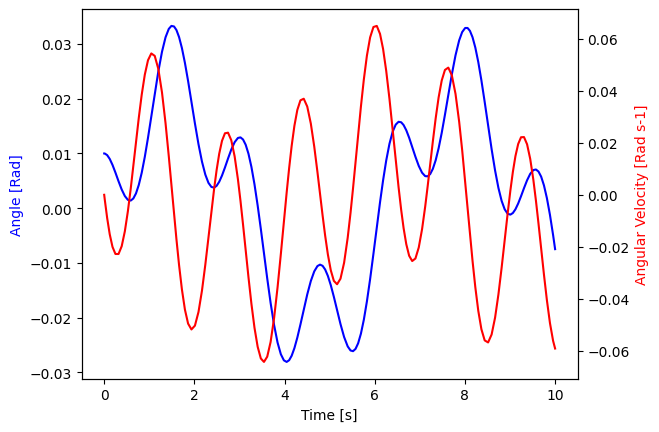

In [3]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_reg.t, result_reg.y[0], c='b')
ax2.plot(result_reg.t, result_reg.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

## Additional Args = Cython C-Struct

In [10]:
%%cython --force 
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin
from libcpp cimport bool as cpp_bool

from CyRK cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType,MAX_STEP, CySolveOutput, PreEvalFunc

cdef struct PendulumArgs:
    # Structure that contains heterogeneous types
    cpp_bool use_drag
    double g
    double l
    double m

cdef void pendulum_diffeq(double* dy_ptr, double t, double* y_ptr, char* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    # Arg pointer still must be listed as a char pointer or it will not work with cysolve_ivp.
    # But now the user can recast that char pointer to the structure they wish.
    cdef PendulumArgs* pendulum_args_ptr = <PendulumArgs*>args_ptr
    # And easily access its members which can be many heterogeneous types.
    cdef double l = pendulum_args_ptr.l
    cdef double m = pendulum_args_ptr.m
    cdef double g = pendulum_args_ptr.g
    cdef double use_drag = pendulum_args_ptr.use_drag

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double y0, y1, torque
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    # External torque
    torque = 0.1 * sin(t)

    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * torque

    if use_drag:
        dy_ptr[1] -= 1.5 * y1

# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_diffeq

    # Define time domain
    cdef double[2] time_span_arr = [0.0, 10.0]
    cdef double* t_span_ptr      = &time_span_arr[0]
    
    # Define initial conditions
    cdef double[2] y0_arr = [0.01, 0.0]
    cdef double* y0_ptr   = &y0_arr[0]
    
    # Define our arguments.
    # We now have a a structure that we need to allocate memory for.
    # For this example, let's do it on the stack. 
    cdef PendulumArgs pendulum_args = PendulumArgs(True, 9.81, 1.0, 1.0)
    # We need to pass in a char pointer to cysolve_ivp, so let's cast the address of the struct to char*
    cdef char* args_ptr = <char*>&pendulum_args

    # It is important that you take the size of the underlying structure and _not_ the `args_ptr` which would just be the size of the pointer PendulumArgs*
    cdef size_t size_of_args = sizeof(pendulum_args)

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        2,  # Number of dependent variables
        method = 1, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_ptr = args_ptr,
        size_of_args = size_of_args
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result

result_drag = run()
print("\n\nIntegration success =", result_drag.success, "\n\tNumber of adaptive time steps required:", result_drag.size)
print("Integration message:", result_drag.message)

Content of stdout:
_cython_magic_db013b47af4f4caa7c0f97385e8032ff0927cd96.cpp
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\jrenaud\.ipython\cython\_cython_magic_db013b47af4f4caa7c0f97385e8032ff0927cd96.cpp(25208): warning C4551: function call missing argument list
   Creating library C:\Users\jrenaud\.ipython\cython\Users\jrenaud\.ipython\cython\_cython_magic_db013b47af4f4caa7c0f97385e8032ff0927cd96.cp311-win_amd64.lib and object C:\Users\jrenaud\.ipython\cython\Users\jrenaud\.ipython\cython\_cython_magic_db013b47af4f4caa7c0f97385e8032ff0927cd96.cp311-win_amd64.exp
Generating code
Finished generating code

Integration success = True 
	Number of adaptive time steps required: 112
Integration message: Integration completed without issue.


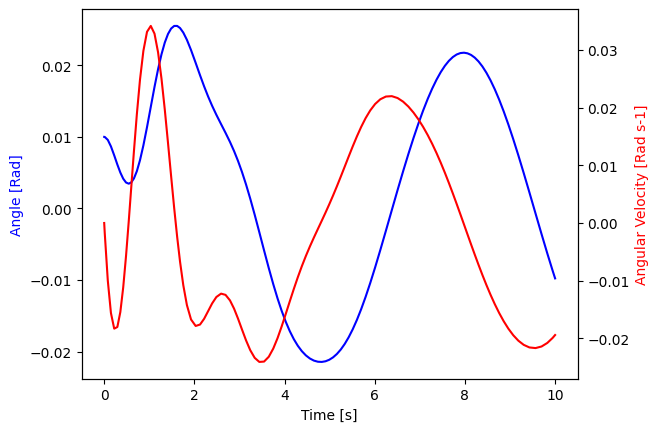

In [11]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_drag.t, result_drag.y[0], c='b')
ax2.plot(result_drag.t, result_drag.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

# Pre-Evaluation Functions

In [6]:
%%cython --force 
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin

from CyRK cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType, MAX_STEP, CySolveOutput, PreEvalFunc

cdef void pendulum_preeval_nodrag(char* output_ptr, double time, double* y_ptr, char* args_ptr) noexcept nogil:
    # Unpack args (in this example we do not need these but they follow the same rules as the Arbitrary Args section discussed above)
    cdef double* args_dbl_ptr = <double*>args_ptr

    # External torque
    cdef double torque = 0.1 * sin(time)

    # Convert output pointer to double pointer so we can store data
    cdef double* output_dbl_ptr = <double*>output_ptr
    output_dbl_ptr[0] = torque
    output_dbl_ptr[1] = 0.0  # No Drag

cdef void pendulum_preeval_withdrag(char* output_ptr, double time, double* y_ptr, char* args_ptr) noexcept nogil:
    # Unpack args (in this example we do not need these but they follow the same rules as the Arbitrary Args section discussed above)
    cdef double* args_dbl_ptr = <double*>args_ptr

    # External torque
    cdef double torque = 0.1 * sin(time)

    # Convert output pointer to double pointer so we can store data
    cdef double* output_dbl_ptr = <double*>output_ptr
    output_dbl_ptr[0] = torque
    output_dbl_ptr[1] = -1.5 * y_ptr[1]  # With Drag


cdef void pendulum_preeval_diffeq(double* dy_ptr, double t, double* y_ptr, char* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:

    # Build other parameters that do not depend on the pre-eval func
    cdef double* args_dbl_ptr = <double*>args_ptr
    cdef double l = args_dbl_ptr[0]
    cdef double m = args_dbl_ptr[1]
    cdef double g = args_dbl_ptr[2]

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Make stack allocated storage for pre eval output
    cdef double[4] pre_eval_storage
    cdef double* pre_eval_storage_ptr = &pre_eval_storage[0]

    # Cast storage to char so we can call function
    cdef char* pre_eval_storage_char_ptr = <char*>pre_eval_storage_ptr

    # Call Pre-Eval Function
    # Note that even though CyRK calls this function a "pre-eval" function, it can be placed anywhere inside the diffeq function. 
    pre_eval_func(pre_eval_storage_char_ptr, t, y_ptr, args_ptr)

    cdef double y0 = y_ptr[0]
    cdef double y1 = y_ptr[1]

    # Use results of pre-eval function to update dy. Note that we are using the double* not the char* here.
    # Even though pre_eval_func was passed the char* it updated the memory that the double* pointed to so we can use it below.
    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * pre_eval_storage_ptr[0] + pre_eval_storage_ptr[1]


# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_preeval_diffeq
    
    # Setup pointer to pre-eval function
    cdef PreEvalFunc pre_eval_func
    
    cdef bint use_drag = True
    if use_drag:
        pre_eval_func = pendulum_preeval_withdrag
    else:
        pre_eval_func = pendulum_preeval_nodrag
    
    # Define time domain
    cdef double[2] time_span_arr = [0.0, 10.0]
    cdef double* t_span_ptr = &time_span_arr[0]
    
    # Define initial conditions
    cdef double[2] y0_arr = [0.01, 0.0]
    cdef double* y0_ptr = &y0_arr[0]
    
    # Define our arguments.
    cdef double[3] args_arr = [1.0, 1.0, 9.81]
    cdef double* args_dbl_ptr = &args_arr[0]
    cdef size_t size_of_args = sizeof(double) * 3

    # To work with cysolve_ivp, we must cast the args ptr to a char pointer
    cdef char* args_ptr = <char*>args_dbl_ptr

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        2,  # Number of dependent variables
        method = 1, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_ptr = args_ptr,
        size_of_args = size_of_args,
        num_extra = 0,
        max_num_steps = 100_000_000,
        max_ram_MB = 2000,
        dense_output = False,
        t_eval = NULL,
        len_t_eval = 0,
        pre_eval_func = pre_eval_func
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result

result_preeval = run()
print("\n\nIntegration success =", result_preeval.success, "\n\tNumber of adaptive time steps required:", result_preeval.size)
print("Integration message:", result_preeval.message)

Content of stdout:
_cython_magic_f7abf9118f7a30e6e9428dfbfd9993bcc8d40002.cpp
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\dense.cpp(155): warning C5051: attribute [[unlikely]] requires at least '/std:c++20'; ignored
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\cysolution.cpp(76): warning C5051: attribute [[unlikely]] requires at least '/std:c++20'; ignored
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\cysolution.cpp(122): warning C5051: attribute [[unlikely]] requires at least '/std:c++20'; ignored
C:\Users\jrenaud\AppData\Local\miniforge3\envs\cyrkdev311\Lib\site-packages\CyRK\cy\cysolution.cpp(234): warning C5051: attribute [[unlikely

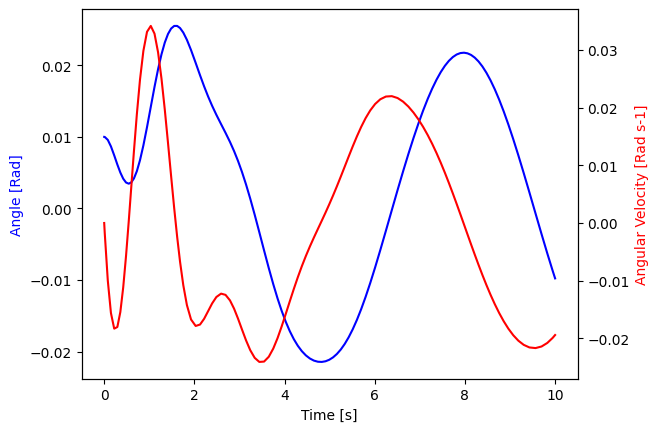

In [7]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_preeval.t, result_preeval.y[0], c='b')
ax2.plot(result_preeval.t, result_preeval.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()